In [1]:
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
from keras.utils import plot_model,multi_gpu_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import Model
from keras.models import load_model
from keras.layers import Input,GlobalAveragePooling2D,Layer,InputSpec
from keras.layers.core import Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils
import keras.backend as K
import keras.layers as kl
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from time import time
import pickle
from AttentionModule import CrossAttention, SoftAttention, ResidualCombine2D
import os, sys, shutil
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"
import cv2
from tqdm import tqdm_notebook
from coord import CoordinateChannel2D
from sklearn.model_selection import KFold
from scipy import misc
from itertools import combinations
pd.options.display.max_colwidth = 100
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

Using TensorFlow backend.


In [2]:
n_gpu=3
n_cpu=1
tf_config= tf.ConfigProto(device_count = {'GPU': n_gpu , 'CPU': n_cpu})
tf_config.gpu_options.allow_growth=True
s=tf.Session(config=tf_config)
K.set_session(s)

In [3]:
ds_folder = 'dataset/all'
ds = np.array(os.listdir(ds_folder))
np.random.shuffle(ds)
ds[:10]

array(['0149a_num1.png', '0521a_num4.png', '0337a_num2.png',
       '0597b_num3.png', '0436a_num2.png', '0592a_num2.png',
       '0479a_num2.png', '1029b_num2.png', '0833c_num2.png',
       '0612c_num1.png'], dtype='<U15')

In [4]:
# kf = KFold(n_splits=5, shuffle=False)
# kf.get_n_splits(ds)

In [5]:
# def generateDatasetAndSave(ids, fold_count, mode):
#     label = []
#     left_path = []
#     right_path = []
#     simCounter = 0
#     diffCounter = 0
#     x = ds[ids]
#     combs = combinations(x,2)
#     combs = list(combs)
#     np.random.shuffle(combs)
#     for l,r in tqdm_notebook(combs):
#         if(int(l[:4]) == int(r[:4])):
#             label.append(1)
#             left_path.append(l)
#             right_path.append(r)
#             simCounter+=1 
#     for l,r in tqdm_notebook(combs):
#         if(int(l[:4]) != int(r[:4])):
#             label.append(0)
#             left_path.append(l)
#             right_path.append(r)
#             diffCounter+=1
#         if(diffCounter==simCounter*10):
#             break
#     df = pd.DataFrame()
#     df['left'] = left_path
#     df['right'] = right_path
#     df['label'] = label
#     if not os.path.exists('dataset/kfold_csvs/fold_'+str(fold_count)):
#         os.mkdir('dataset/kfold_csvs/fold_'+str(fold_count))
#     df.to_csv('dataset/kfold_csvs/fold_'+str(fold_count)+'/'+mode+'.csv')

In [231]:
def VGGNet():
    image_input = Input(shape=(64,64,1),name='image_input')
#     x = CoordinateChannel2D()(image_input)
    x = kl.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', name='block1_conv1')(image_input)
    x = kl.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', name='block1_conv2')(x)
    x = kl.BatchNormalization()(x)
    x_red = kl.MaxPooling2D(pool_size=(2,2), padding='same', name='block1_reduction_conv')(x)    
    xsa1,samap1 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(x.shape[-1]),name='soft_attention_1')(x)
    xsa1 = kl.MaxPooling2D(pool_size=(2,2),padding='same')(xsa1)
    x = kl.Concatenate()([x_red,xsa1])
#     x,sa1g1,sa1g2=ResidualCombine2D(ch_in=int(sa1.shape[-1]),ch_out=64)([x,sa1])
#     x = kl.BatchNormalization()(x)
    x = kl.Activation('relu')(x)
    x = kl.Dropout(0.5)(x)

    x = kl.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', name='block2_conv1')(x)
    x = kl.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', name='block2_conv2')(x)
    x = kl.BatchNormalization()(x)
    x_red = kl.MaxPooling2D(pool_size=(2,2), padding='same', name='block2_reduction_conv')(x)
    xsa2,samap2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(x.shape[-1]),name='soft_attention_2')(x)
    xsa2 = kl.MaxPooling2D(pool_size=(2,2),padding='same')(xsa2)
    x = kl.Concatenate()([x_red,xsa2])
#     x = kl.BatchNormalization()(x)
    x = kl.Activation('relu')(x)
    x = kl.Dropout(0.5)(x)

#     x = kl.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', name='block3_conv1')(x)
#     x = kl.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', name='block3_conv2')(x)
#     x = kl.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', name='block3_conv3')(x)
#     x = kl.Conv2D(filters=256, kernel_size=2, strides=2, activation='relu', padding='same', name='block3_reduction_conv')(x)
# #     sa3,samap3 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(x.shape[-1]))(x)
# #     x,sa3g1,sa3g2=ResidualCombine2D(ch_in=int(sa3.shape[-1]),ch_out=256)([x,sa3])
# #     x = kl.BatchNormalization()(x)
#     x = kl.Dropout(0.5)(x)

#     x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block4_conv1')(x)
#     x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block4_conv2')(x)
#     x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block4_conv3')(x)
#     # x = CoordinateChannel2D(use_radius=True)(x)
# #     x, samap, g = SelfAttention(ch=512, name='self_attention')(x)
#     x = kl.Conv2D(filters=512, kernel_size=2, strides=2, activation='relu', padding='same', name='block4_reduction_conv')(x)
#     x = kl.BatchNormalization()(x)
#     x = kl.Dropout(0.5)(x)

#     x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block5_conv1')(x)
#     x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block5_conv2')(x)
#     x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block5_conv3')(x)
# #     x, amaps = SoftAttention(ch=512, m=32, name='soft_attention')(x)
#     x = kl.Conv2D(filters=512, kernel_size=2, strides=2, activation='relu', padding='same', name='block5_reduction_conv')(x)
    return Model(image_input,x,name='imgModel')

In [232]:
feat_ext_A = VGGNet()
feat_ext_A.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 64, 64)   640         image_input[0][0]                
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 64, 64, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 64, 64, 64)   256         block1_conv2[0][0]               
__________________________________________________________________________________________________
soft_atten

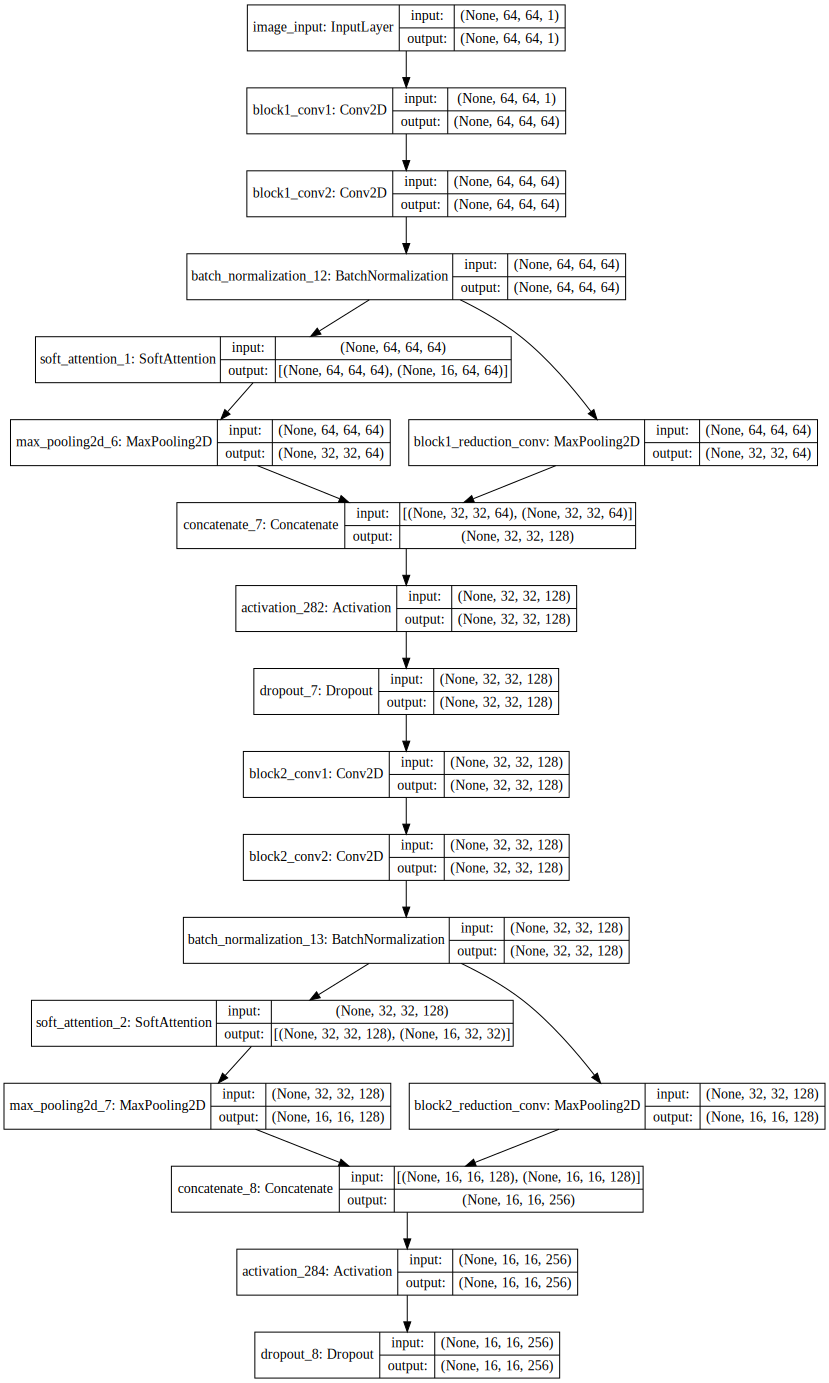

In [233]:
SVG(model_to_dot(feat_ext_A,show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

## extract features from the stem model

In [234]:
l_inp = kl.Input(shape=(64,64,1),name='l')
r_inp = kl.Input(shape=(64,64,1),name='r')
left_feats = feat_ext_A(l_inp)
right_feats = feat_ext_A(r_inp)


## apply cross attention between the extracted features

In [235]:
att_l_1,l_map_1 = CrossAttention(ch=int(left_feats.shape[-1]),name='ca_l2r_1')([left_feats,right_feats]) #[k,q]
att_l_1 = kl.BatchNormalization()(att_l_1)
att_l_2,l_map_2 = CrossAttention(ch=int(left_feats.shape[-1]),name='ca_l2r_2')([left_feats,right_feats]) #[k,q]
att_l_2 = kl.BatchNormalization()(att_l_2)
att_l_conc = kl.Concatenate(name='ca_l2r_concat')([att_l_1,att_l_2])
att_l_conc = kl.Activation('relu')(att_l_conc)
l2r_comb,l2r_g1,l2r_g2 = ResidualCombine2D(ch_in=int(att_l_conc.shape[-1]),ch_out=512,name='ca_l2r_comb')([left_feats,att_l_conc])
l2r_comb = kl.BatchNormalization()(l2r_comb)

att_r_1,r_map_1 = CrossAttention(ch=int(right_feats.shape[-1]),name='ca_r2l_1')([right_feats,left_feats])#[k,q]
att_r_1 = kl.BatchNormalization()(att_r_1)
att_r_2,r_map_2 = CrossAttention(ch=int(right_feats.shape[-1]),name='ca_r2l_2')([right_feats,left_feats])#[k,q]
att_r_2 = kl.BatchNormalization()(att_r_2)
att_r_conc = kl.Concatenate(name='ca_r2l_concat')([att_r_1,att_r_2])
att_r_conc = kl.Activation('relu')(att_r_conc)
r2l_comb,r2l_g1,r2l_g2 = ResidualCombine2D(ch_in=int(att_r_conc.shape[-1]),ch_out=512,name='ca_r2l_comb')([right_feats,att_r_conc])
r2l_comb = kl.BatchNormalization()(r2l_comb)

## combine the attended features

In [236]:
all_concat = kl.Concatenate()([l2r_comb,r2l_comb])
all_concat = kl.Activation('relu')(all_concat)

## futher joint feature extraction

In [237]:

x = kl.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', name='block3_conv1')(all_concat)
x = kl.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', name='block3_conv2')(x)
x = kl.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', name='block3_conv3')(x)
x = kl.BatchNormalization()(x)
x_red = kl.MaxPooling2D(pool_size=(2,2),padding='same', name='block3_reduction_conv')(x)
xsa3,samap3 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(x.shape[-1]),name='soft_attention_3')(x)
xsa3 = kl.MaxPooling2D(pool_size=(2,2),padding='same')(xsa3)
x = kl.Concatenate()([x_red,xsa3])
x = kl.Activation('relu')(x)
x = kl.Dropout(0.5)(x)

x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block4_conv1')(x)
x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block4_conv2')(x)
x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block4_conv3')(x)
x = kl.BatchNormalization()(x)
x_red = kl.MaxPooling2D(pool_size=(2,2),padding='same', name='block4_reduction_conv')(x)
xsa4,samap4 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(x.shape[-1]),name='soft_attention_4')(x)
xsa4 = kl.MaxPooling2D(pool_size=(2,2),padding='same')(xsa4)
x = kl.Concatenate()([x_red,xsa4])
x = kl.Activation('relu')(x)
x = kl.Dropout(0.5)(x)

x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block5_conv1')(x)
x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block5_conv2')(x)
x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block5_conv3')(x)
x = kl.BatchNormalization()(x)
x_red = kl.MaxPooling2D(pool_size=(2,2), padding='same', name='block5_reduction_conv')(x)
xsa5,samap5 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(x.shape[-1]),name='soft_attention_5')(x)
xsa5 = kl.MaxPooling2D(pool_size=(2,2),padding='same')(xsa5)
x = kl.Concatenate()([x_red,xsa5])
x = kl.Activation('relu')(x)
x = kl.Dropout(0.5)(x)

g = kl.Flatten()(x)
g = kl.Dropout(0.5)(g)
g = kl.Dense(2,activation='softmax',name='y')(g)
model = Model(inputs = [l_inp,r_inp],outputs = g)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
l (InputLayer)                  (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
r (InputLayer)                  (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
imgModel (Model)                (None, 16, 16, 256)  361184      l[0][0]                          
                                                                 r[0][0]                          
__________________________________________________________________________________________________
ca_l2r_1 (CrossAttention)       [(None, 16, 16, 256) 148032      imgModel[1][0]                   
          

## view the model in SVG mode

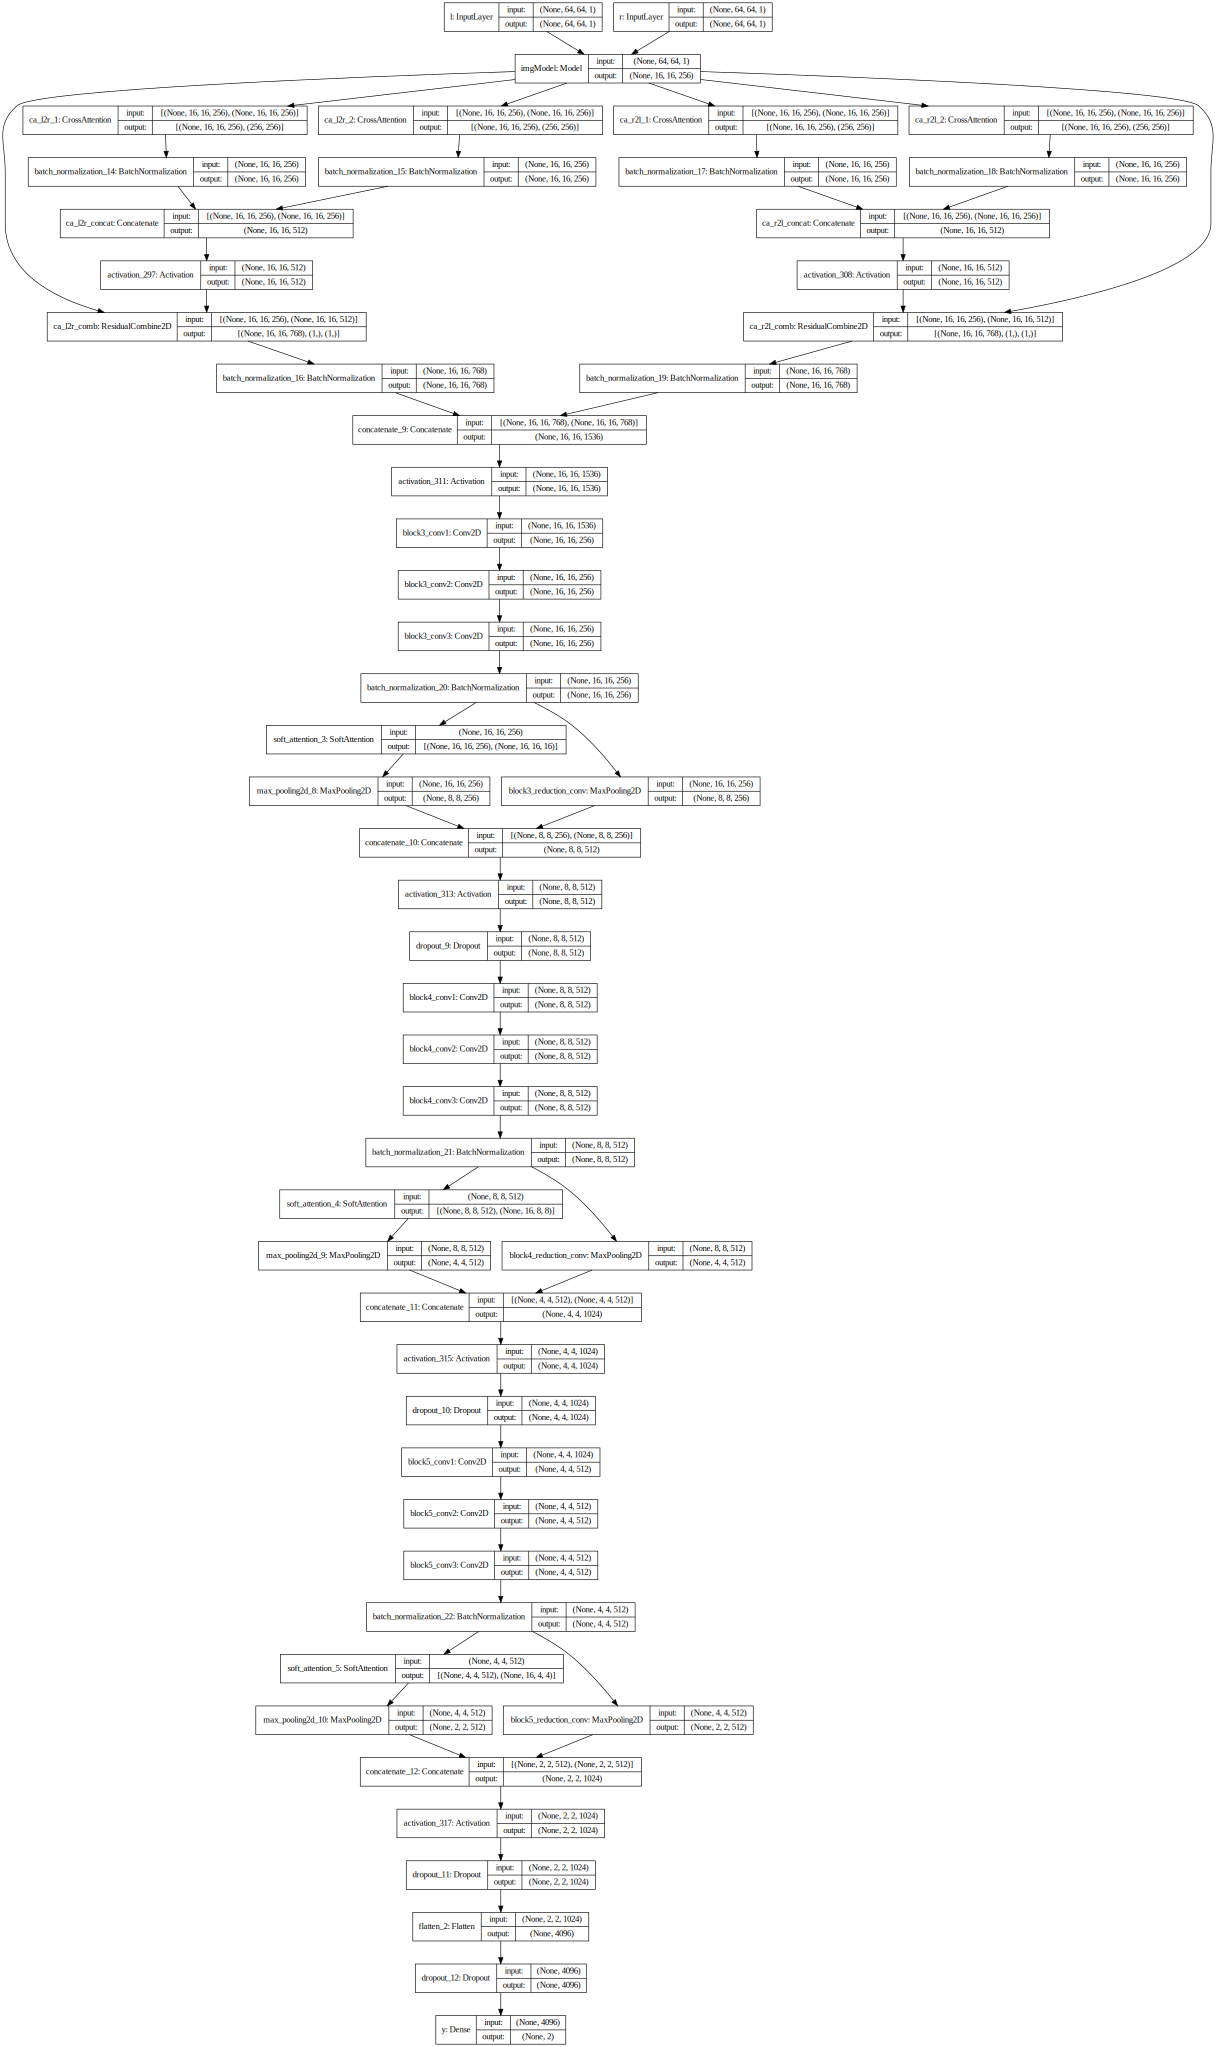

In [238]:
SVG(model_to_dot(model,show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

## load data for a given fold

In [14]:
nb_fold = 1
df_tr = pd.read_csv('dataset/kfold_csvs/fold_{0}/train.csv'.format(nb_fold))
df_v = pd.read_csv('dataset/kfold_csvs/fold_{0}/val.csv'.format(nb_fold))
display(df_tr.shape,df_v.shape)
df_tr = df_tr.sort_values(by=['left','right','label']).reset_index()
df_v = df_v.sort_values(by=['left','right','label']).reset_index()

(504207, 4)

(30459, 4)

## visualize the ground truth data

In [15]:
display(df_tr.head())

,index,Unnamed: 0,left,right,label
0,44642,44642,0001a_num1.png,0001b_num3.png,1
1,67417,67417,0001a_num1.png,0017b_num1.png,0
2,230576,230576,0001a_num1.png,0118c_num3.png,0
3,439468,439468,0001a_num1.png,0202c_num1.png,0
4,154608,154608,0001a_num1.png,0343a_num3.png,0


In [16]:
df_tr.shape

(504207, 5)

In [17]:
display(df_v.head()),df_v.shape

,index,Unnamed: 0,left,right,label
0,1028,1028,0001b_num1.png,0001c_num1.png,1
1,17828,17828,0001b_num1.png,0050c_num2.png,0
2,29813,29813,0001b_num1.png,0182a_num2.png,0
3,4741,4741,0001b_num1.png,0373a_num3.png,0
4,22296,22296,0001b_num1.png,0539a_num2.png,0


(None, (30459, 5))

## function for datagenerator

In [18]:
def datagen(ds,batch_size=128,seq=False,mode=''):
    counter=0
    l,r,y,names = [],[],[],[]
    idx = 0
    while True:
        i=np.random.randint(0,ds.shape[0],1)[0]
        if seq:
            i = idx
            idx+=1
        d = ds.iloc[i]        
        l.append((255.0 - np.expand_dims(cv2.imread(os.path.join(ds_folder,d.left),0),axis=-1))/255.0)
        r.append((255.0 - np.expand_dims(cv2.imread(os.path.join(ds_folder,d.right),0),axis=-1))/255.0)
#         im = np.concatenate((l,r),axis=-1)  
        names.append([d.left,d.right])
        y.append(d.label)
        counter+=1
        
        r.append((255.0 - np.expand_dims(cv2.imread(os.path.join(ds_folder,d.left),0),axis=-1))/255.0)
        l.append((255.0 - np.expand_dims(cv2.imread(os.path.join(ds_folder,d.right),0),axis=-1))/255.0)
#         im = np.concatenate((l,r),axis=-1)  
        names.append([d.right,d.left])
        y.append(d.label)
        
        counter+=1
#         print('---',mode,'---',names)
        if ds.shape[0]==idx:
            idx = 0
        if counter==batch_size:
            inputs={
                'l':np.array(l)
                ,'r':np.array(r)
            }
            outputs={
#                 'y':np.array(y)
                'y':np_utils.to_categorical(y,num_classes=2)
                ,'names':np.array(names)
            }
            yield inputs,outputs
            counter=0
            l,r,y,names = [],[],[],[]

## function for categorical focal loss

In [307]:
def categorical_focal_loss(gamma=2.0, alpha=0.75):
    def focal_loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        cross_entropy = -y_true*K.log(y_pred)
#         print(K.get_value(y_true))
        alpha_factor = K.ones_like(y_true)*alpha
        a_t = K.tf.where(K.equal(K.argmax(y_true),1),alpha_factor, 1.0-alpha_factor)
#         print(a)
        weight = a_t * y_true * K.pow((1-y_pred), gamma)
        loss = weight * cross_entropy
        loss = K.sum(loss, axis=1)
        return loss    
    return focal_loss

In [281]:
tr_batch_size=192
val_batch_size=512
tr_gen = datagen(df_tr,batch_size=tr_batch_size,seq=True,mode='train')
v_gen = datagen(df_v,batch_size=val_batch_size,seq=True,mode='val')

In [282]:
inputs,outputs=next(tr_gen)
l,r,y,n = inputs['l'],inputs['r'],outputs['y'],outputs['names']

In [283]:
l.shape,r.shape,y.shape,n.shape

((192, 64, 64, 1), (192, 64, 64, 1), (192, 2), (192, 2))

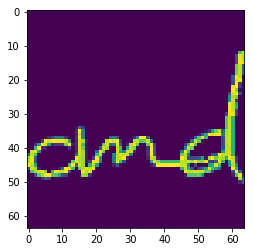

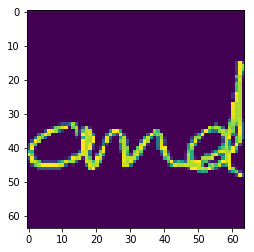

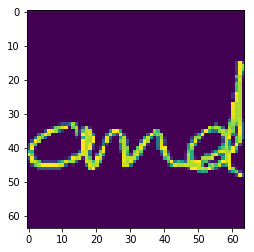

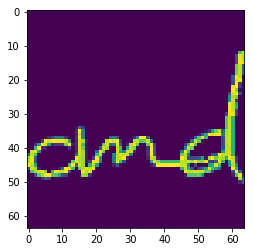

In [284]:
plt.imshow(l[0][:,:,0])
plt.show()
plt.imshow(r[0][:,:,0])
plt.show()
plt.imshow(l[1][:,:,0])
plt.show()
plt.imshow(r[1][:,:,0])
plt.show()

In [266]:
p_l = feat_ext_A.predict(l)

In [267]:
p_l.shape

(192, 16, 16, 256)

In [268]:
y_true = np.array([0.0,1.0])
y_pred = np.array([0.8,0.2])
cce = -y_true*np.log(y_pred)
cce

array([0.        , 1.60943791])

In [269]:
alpha = 0.95 if np.argmax(y_true)==1 else 1 - 0.95
print(alpha)
gamma = 2.0
w = alpha * y_true * np.power((1.0-y_pred), gamma)
w

0.95


array([0.   , 0.608])

In [270]:
w*cce

array([0.        , 0.97853825])

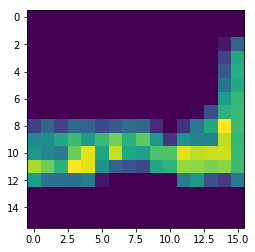

In [271]:
plt.imshow(p_l[0][:,:,92])

# Experiments
- images are input as concatenated
    - equal class weights
    - unbalanced class weights
    - focal loss
- images are input as siamese inputs
    - equal class weights
    - unbalanced class weights
    - focal loss

## This is for unbalanced class

In [272]:
total = df_tr.shape[0]
pos = df_tr[df_tr['label']==1].shape[0]
neg = total-pos
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.55, 1: 5.5}

In [308]:
model.compile(loss=categorical_focal_loss(),optimizer=Adam(lr=0.0001,decay=1e-06),metrics=['accuracy'])

In [309]:
parallel_model=multi_gpu_model(model, gpus=3)
parallel_model.compile(loss=categorical_focal_loss(),optimizer=Adam(lr=0.0001,decay=1e-06),metrics=['accuracy']) #For multi GPU
parallel_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
l (InputLayer)                  (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
r (InputLayer)                  (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
lambda_25 (Lambda)              (None, 64, 64, 1)    0           l[0][0]                          
__________________________________________________________________________________________________
lambda_26 (Lambda)              (None, 64, 64, 1)    0           r[0][0]                          
__________________________________________________________________________________________________
lambda_27 

In [310]:
class MultiGPUCheckpoint(ModelCheckpoint):    
    def set_model(self, model):
        if isinstance(model.layers[-2], Model):
            self.model = model.layers[-2]
        else:
            self.model = model

In [311]:
if not os.path.exists('./checkpoints/ICFHR2020/'):
    os.mkdir('./checkpoints/ICFHR2020/')
mc=MultiGPUCheckpoint(filepath='./checkpoints/ICFHR2020/cross_attention_residual_vgg_fold_{0}.h5'.format(nb_fold),monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=1)
es=EarlyStopping(patience=20,monitor='val_loss',min_delta=0.0001,mode='auto')
tb=TensorBoard(log_dir="./runs/cross_attention_residual_vgg_fold_{0}_{1}".format(nb_fold,time()))

## load weights if any

In [312]:
model.load_weights('./checkpoints/ICFHR2020/cross_attention_residual_vgg_fold_1.h5',by_name=True,skip_mismatch=True)

/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/keras/engine/saving.py:1008: UserWarning: Skipping loading of weights for layer imgModel due to mismatch in shape ((3, 3, 128, 128) vs (64, 64, 2, 2)).
  weight_values[i].shape))
/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/keras/engine/saving.py:1008: UserWarning: Skipping loading of weights for layer imgModel due to mismatch in shape ((128,) vs (64,)).
  weight_values[i].shape))
/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/keras/engine/saving.py:1008: UserWarning: Skipping loading of weights for layer imgModel due to mismatch in shape ((128,) vs (3, 3, 128, 128)).
  weight_values[i].shape))
/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/keras/engine/saving.py:1008: UserWarning: Skipping loading of weights for layer imgModel due to mismatch in shape ((128, 3, 3, 1, 16) vs (128,)).
  weight_values[i].shape))
/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-p

## start the training

In [ ]:
Epochs=100
h=parallel_model.fit_generator(tr_gen,initial_epoch=47,callbacks=[mc,es,tb],epochs=Epochs,steps_per_epoch=2*((df_tr.shape[0]//tr_batch_size)+1)
                      ,validation_data=v_gen, validation_steps=2*60, verbose=1,class_weight=class_weight)

Epoch 48/100
3692/5254 [====================>.........] - ETA: 7:04 - loss: 0.1402 - acc: 0.1931

# Evaluation

In [70]:
model.load_weights('./checkpoints/ICFHR2020/cross_attention_residual_vgg_fold_1.h5')

In [72]:
v_gen = datagen(df_v,batch_size=256,seq=True)
inputs,outputs=next(v_gen)
test_x,test_y = inputs,outputs['y']

## Make post processing models to visualize attention maps

In [73]:
soft_attention_1 = Model(feat_ext_A.inputs,feat_ext_A.get_layer('soft_attention_1').output)
feats_sa1,maps_sa1 = soft_attention_1.predict(test_x['l'])
soft_attention_2 = Model(feat_ext_A.inputs,feat_ext_A.get_layer('soft_attention_2').output)
feats_sa2,maps_sa2 = soft_attention_2.predict(test_x['l'])
soft_attention_3 = Model(model.inputs,model.get_layer('soft_attention_3').output)
feats_sa3,maps_sa3 = soft_attention_3.predict(test_x)
soft_attention_4 = Model(model.inputs,model.get_layer('soft_attention_4').output)
feats_sa4,maps_sa4 = soft_attention_4.predict(test_x) 
soft_attention_5 = Model(model.inputs,model.get_layer('soft_attention_5').output)
feats_sa5,maps_sa5 = soft_attention_5.predict(test_x)




ca_l2r_comb_model = Model(model.inputs,model.get_layer('ca_l2r_comb').output)
f_ca_l2r_comb,l2r_g1,l2r_g2 = ca_l2r_comb_model.predict(test_x)

ca_r2l_comb_model = Model(model.inputs,model.get_layer('ca_r2l_comb').output)
f_ca_r2l_comb,r2l_g1,r2l_g2 = ca_r2l_comb_model.predict(test_x)

ca_l2r_1_model = Model(model.inputs,model.get_layer('ca_l2r_1').output)
f_ca_l2r_1,maps_l2r_1 = ca_l2r_1_model.predict(test_x)

ca_l2r_2_model = Model(model.inputs,model.get_layer('ca_l2r_2').output)
f_ca_l2r_2,maps_l2r_2 = ca_l2r_2_model.predict(test_x)

ca_r2l_1_model = Model(model.inputs,model.get_layer('ca_r2l_1').output)
f_ca_r2l_1,maps_r2l_1 = ca_r2l_1_model.predict(test_x)

ca_r2l_2_model = Model(model.inputs,model.get_layer('ca_r2l_2').output)
f_ca_r2l_2,maps_r2l_2 = ca_r2l_2_model.predict(test_x)

## check how much importance is being given to attention by the model

In [74]:
l2r_g1,l2r_g2,r2l_g1,r2l_g2

(array([1.265662, 1.265662, 1.265662, 1.265662, 1.265662, 1.265662,
        1.265662, 1.265662, 1.265662, 1.265662, 1.265662, 1.265662,
        1.265662, 1.265662, 1.265662, 1.265662, 1.265662, 1.265662,
        1.265662, 1.265662, 1.265662, 1.265662, 1.265662, 1.265662,
        1.265662, 1.265662, 1.265662, 1.265662, 1.265662, 1.265662,
        1.265662, 1.265662, 1.265662, 1.265662, 1.265662, 1.265662,
        1.265662, 1.265662, 1.265662, 1.265662, 1.265662, 1.265662,
        1.265662, 1.265662, 1.265662, 1.265662, 1.265662, 1.265662,
        1.265662, 1.265662, 1.265662, 1.265662, 1.265662, 1.265662,
        1.265662, 1.265662, 1.265662, 1.265662, 1.265662, 1.265662,
        1.265662, 1.265662, 1.265662, 1.265662, 1.265662, 1.265662,
        1.265662, 1.265662, 1.265662, 1.265662, 1.265662, 1.265662,
        1.265662, 1.265662, 1.265662, 1.265662, 1.265662, 1.265662,
        1.265662, 1.265662, 1.265662, 1.265662, 1.265662, 1.265662,
        1.265662, 1.265662, 1.265662, 1.265662, 

## combine the left maps and right maps respectively

In [75]:
mapl  = maps_l2r_1+maps_l2r_2
mapl.shape
mapr  = maps_r2l_1+maps_r2l_2
mapr.shape

(256, 256, 256)

In [76]:
feats_sa3.shape,maps_sa3.shape, f_ca_l2r_1.shape,maps_l2r_1.shape

((256, 16, 16, 256), (256, 16, 16, 16), (256, 16, 16, 256), (256, 256, 256))

In [77]:
image_index = 1
print(outputs['names'][image_index])

['0001c_num1.png' '0001b_num1.png']


In [78]:
preds = model.predict(test_x)

In [79]:
preds[image_index]

array([0.07911112, 0.9208889 ], dtype=float32)

## Get important pixels to query

In [80]:
resized_left_img = cv2.resize(test_x['l'][image_index],(16,16),cv2.INTER_CUBIC)
resized_right_img = cv2.resize(test_x['r'][image_index],(16,16),cv2.INTER_CUBIC)

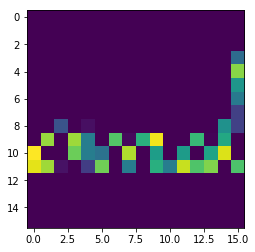

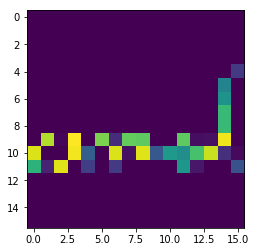

In [81]:
plt.imshow(resized_left_img)
plt.show()
plt.imshow(resized_right_img)
plt.show()

In [82]:
def getRowCol(point):
    row = point//16
    col = point%16
    return row,col

In [83]:
# right_pixel_num = (row*16)+col
# print('right_pixel_num:',right_pixel_num)
# max_idx,max_val=0,0
# matches_dict={} #keys = left_pixels
# prev = -1
# for i in range(maps_r2l_2[image_index].shape[0]):
#     argmax=np.argmax(maps_r2l_2[image_index][i])
# #     print(np.around(maps_r2l_1[image_index][i],2))
#     prob=maps_r2l_2[image_index][i][argmax]
#     if argmax not in matches_dict.keys():
#         matches_dict[argmax] = [i]
#     else:
#         matches_dict[argmax].append(i)
#     if prob>=max_val:
#         max_val=prob
#         max_idx=i
#     print('right pxl {0} --> left pxl {1} : conf {2:4f}, max_idx : {3}, max_val : {4}'.format(i,argmax,prob,max_idx,max_val))

# Visualize Cross Attention

# of query pixels (useful pixels from right image): 40
matched left_points: 0


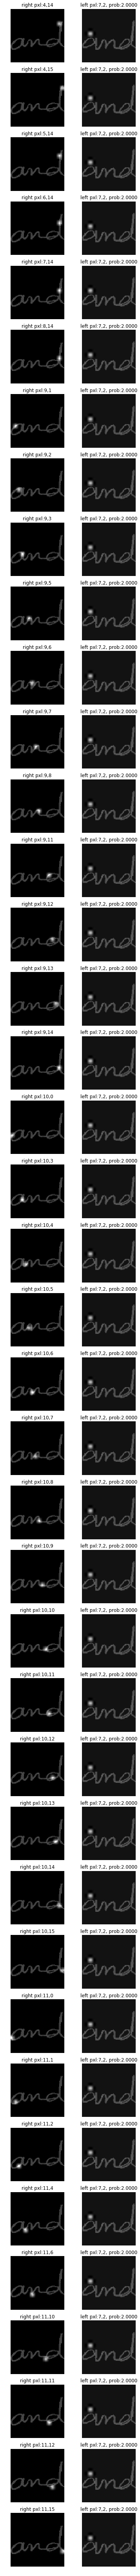

In [84]:
'''
To visualize a right image query pixel (query image) 'q_pix' 
that matches with k pixels of left image (key image)
- chose map_r2l_<x>
- select a row 'r' in it.
- reshap to 16x16 and resize to 64x64.
- apply as mask on left image.
'''

shape = (16,16)
right_useful_pixels = []
for i in range(len(resized_right_img)):
    for j in range(len(resized_right_img)):
        if resized_right_img[i][j] > 0:
            right_useful_pixels.append([i,j])
            
left_useful_pixels = []
for i in range(len(resized_left_img)):
    for j in range(len(resized_left_img)):
        if resized_left_img[i][j] > 0:
            left_useful_pixels.append([i,j])
            
print('# of query pixels (useful pixels from right image):',len(right_useful_pixels))
f, axarr = plt.subplots(nrows=len(right_useful_pixels),ncols=2,figsize=(6,3*len(right_useful_pixels)))

counter=0
left_points = 0
for i,j in right_useful_pixels:# no transparent/black pixels
#     print(i,j)
    pixel_num = (i*16)+j
#     print('pixel_num:',pixel_num)
    argmax=np.argmax(mapr[image_index][pixel_num])
    prob=mapr[image_index][pixel_num][argmax]
#     print('argmax:',argmax)
    row,col = getRowCol(argmax)
#     print([row,col])
    if [row,col] in left_useful_pixels:
        left_points += 1
        left_useful_pixels.remove([row,col])
    
    key_point = np.zeros((16,16))
    key_point[i][j] = 1.0
    resized_key_point = cv2.resize(key_point,(64,64),cv2.INTER_CUBIC)
    axarr[counter,0].imshow(resized_key_point,cmap='gray')
    axarr[counter,0].imshow(np.squeeze(test_x['r'][image_index],-1),alpha=0.3,cmap='gray')
    
    axarr[counter,1].imshow(cv2.resize(mapr[image_index][pixel_num].reshape(shape),(64,64),interpolation=cv2.INTER_CUBIC),cmap='gray')
    axarr[counter,1].imshow(np.squeeze(test_x['l'][image_index],-1),alpha=0.3,cmap='gray')
    axarr[counter,0].set_title('right pxl:{0},{1}'.format(i,j))
    axarr[counter,1].set_title('left pxl:{0},{1}, prob:{2:.4f}'.format(row,col,prob))
    axarr[counter,0].axis('off')
    axarr[counter,1].axis('off')
    counter+=1
    
print('matched left_points:',left_points)

## See all CA maps

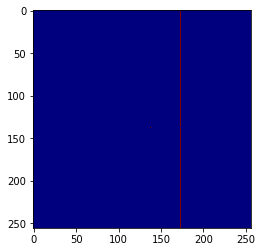

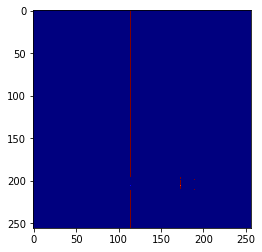

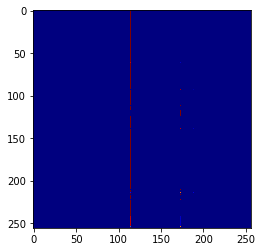

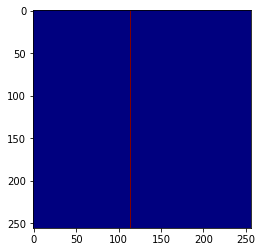

In [85]:
plt.imshow(maps_l2r_1[image_index],cmap='jet')
plt.show()
plt.imshow(maps_l2r_2[image_index],cmap='jet')
plt.show()
plt.imshow(maps_r2l_1[image_index],cmap='jet')
plt.show()
plt.imshow(maps_r2l_2[image_index],cmap='jet')
plt.show()

-----**********visualize SA1 maps************-----


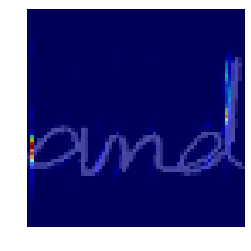

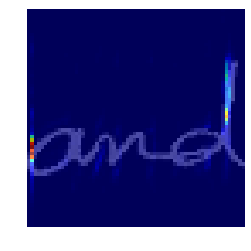

-----**********visualize SA2 maps************-----


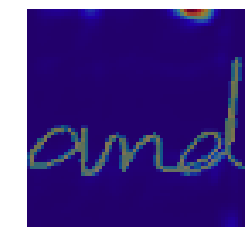

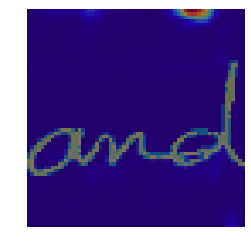

-----**********visualize SA3 maps************-----


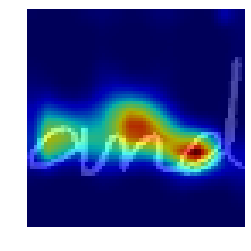

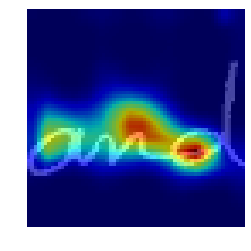

-----**********visualize SA4 maps************-----


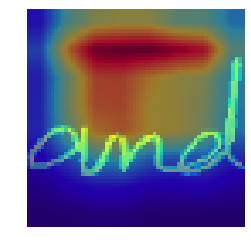

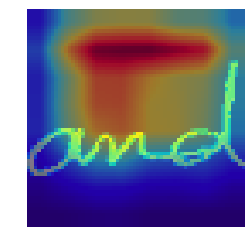

-----**********visualize SA5 maps************-----


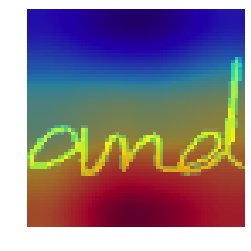

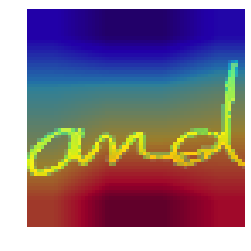

In [86]:
print('-----**********visualize SA1 maps************-----')
plt.axis('off')
plt.imshow(cv2.resize(maps_sa1[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_CUBIC),cmap='jet')
plt.imshow(np.squeeze(test_x['l'][image_index],-1),cmap='gray',alpha=0.3)
plt.show()
print("================================")
plt.axis('off')
plt.imshow(cv2.resize(maps_sa1[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_CUBIC),cmap='jet')
plt.imshow(np.squeeze(test_x['r'][image_index],-1),cmap='gray',alpha=0.3)
plt.show()

print('-----**********visualize SA2 maps************-----')
plt.axis('off')
plt.imshow(np.squeeze(test_x['l'][image_index],-1))
plt.imshow(cv2.resize(maps_sa2[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
plt.show()
print("================================")
plt.axis('off')
plt.imshow(np.squeeze(test_x['r'][image_index],-1))
plt.imshow(cv2.resize(maps_sa2[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
plt.show()

print('-----**********visualize SA3 maps************-----')
plt.axis('off')

plt.imshow(cv2.resize(maps_sa3[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_LINEAR),cmap='jet')
plt.imshow(np.squeeze(test_x['l'][image_index],-1),cmap='gray',alpha=0.3)
plt.show()
print("================================")
plt.axis('off')

plt.imshow(cv2.resize(maps_sa3[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_LINEAR),cmap='jet')
plt.imshow(np.squeeze(test_x['r'][image_index],-1),cmap='gray',alpha=0.3)
plt.show()



print('-----**********visualize SA4 maps************-----')
plt.axis('off')
plt.imshow(np.squeeze(test_x['l'][image_index],-1))
plt.imshow(cv2.resize(maps_sa4[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_LINEAR),cmap='jet',alpha=0.5)
plt.show()
print("================================")
plt.axis('off')
plt.imshow(np.squeeze(test_x['r'][image_index],-1))
plt.imshow(cv2.resize(maps_sa4[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_LINEAR),cmap='jet',alpha=0.5)
plt.show()

print('-----**********visualize SA5 maps************-----')
plt.axis('off')
plt.imshow(np.squeeze(test_x['l'][image_index],-1))
plt.imshow(cv2.resize(maps_sa5[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
plt.show()
print("================================")
plt.axis('off')
plt.imshow(np.squeeze(test_x['r'][image_index],-1))
plt.imshow(cv2.resize(maps_sa5[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_LINEAR),cmap='jet',alpha=0.5)
plt.show()

In [ ]:
mapr[image_index].min(),mapr[image_index].max()

In [ ]:
# sn.heatmap(maps2_r[image_index][j+i*26].reshape((26,26)),cmap='jet')
image_idx = [0,11,60,80,100,120]
for image_index in image_idx:
    sn.heatmap(cv2.resize(maps_sa3[image_index].sum(axis=0),(64,64),interpolation=cv2.INTER_CUBIC),cmap='jet')
    

# Evaluate the network
- Evaluating network VGG Cross and Soft Attention

In [ ]:
classnames=['Inter','Intra']

In [ ]:
v_gen = datagen(df_v,batch_size=512,seq=True)
arr_test_y = []
arr_preds = []
for i in tqdm_notebook(range(1+int(df_v.shape[0]/val_batch_size))):
    inputs,outputs=next(v_gen)
    test_x,test_y = inputs,outputs['y']
    predictions = parallel_model.predict(test_x)
    arr_test_y+=list(test_y)
    arr_preds+=list(predictions)
arr_test_y = np.array(arr_test_y)
arr_preds = np.array(arr_preds)
print(arr_test_y.shape)
print(arr_preds.shape)

In [ ]:
arr_preds_logits = arr_preds.argmax(-1)
print(arr_preds[image_index],arr_preds_logits[image_index],arr_test_y[image_index])
# arr_preds_logits = np.array([1 if a>0.5 else 0 for a in arr_preds])
# arr_preds_logits,arr_test_y.argmax(-1)


In [ ]:
df = pd.DataFrame()
f = classification_report(arr_test_y.argmax(-1),arr_preds_logits,target_names=classnames,output_dict=True)
df = df.from_dict(f)
display(df.T)

In [ ]:
# true negatives is:math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
# :math:`C_{1,1}` and false positives is :math:`C_{0,1}`

In [ ]:
cm=metrics.confusion_matrix(arr_test_y.argmax(-1),arr_preds_logits)
cm

In [ ]:

def get_FPR_intra(cm):
    FP = cm[0][1]
    TN = cm[0][0]
    return FP/(FP+TN)
def get_FNR_intra(cm):
    FN = cm[1][0]
    TP = cm[1][1]
    return FN/(FN+TP)

In [ ]:
get_FPR_intra(cm)*100,get_FNR_intra(cm)*100

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(3, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
plot_confusion_matrix(cm=cm,cmap='YlOrBr',target_names=classnames, normalize=False)

In [ ]:
# try:
#     f,ax=plt.subplots(8,8)    
#     f.subplots_adjust(hspace=.20,wspace=.1)
#     f.set_size_inches(20,20)
#     for i in range(8):
#         for j in range(8):
# #             print(feats[j+i*8].shape)
#             ax[i,j].imshow(test_x[j+i*8][:,:,0],cmap=plt.get_cmap('gray'),alpha=0.8)
#             ax[i,j].imshow(test_x[j+i*8][:,:,1],cmap=plt.get_cmap('gray'),alpha=0.5)
#             ax[i,j].axis('off')
#             ax[i,j].set_title(str(j+i*8)+'-a:'+classnames[np.argmax(test_y[j+i*8])]+',p:'+classnames[np.argmax(predictions[j+i*8])])
#     #         print(np.argmax(y[j+i*8]), end=',')
# except Exception as ex:
#     print(ex)